In [97]:
# run dependencies

import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [98]:
# CSV FILES
player_appearances_csv = "Data/player_appearances.csv"
players_csv = "Data/players.csv"
matches_csv = "Data/matches.csv"
data2021_csv = "Data/2021.csv"

In [99]:
# HISOTRIC PLAYER APPEARANCES CSV FILE
file1_18624records = "Data/player_appearances.csv"
playerApps_df = pd.read_csv(file1_18624records)
playerApps_df["Name"] = playerApps_df["given_name"] + " " + playerApps_df["family_name"]

playersApps_df_grp = playerApps_df[["match_id", "player_id", "Name"]].groupby(["player_id", "Name"]).nunique("match_id")
playersApps_df_grp

,,match_id
player_id,Name,
P-00002,Javad Zarincheh,3
P-00004,Krasimir Balakov,10
P-00007,Stephen Malcolm,2
P-00008,not applicable Rivaldo,14
P-00015,Vladimir Soria,3
...,...,...
P-09989,Ziad Jaziri,6
P-09990,Bernardo Redín,3
P-09993,Francisco Silva,3


In [100]:
teams_2022 = ['Qatar', 'Netherlands', 'Senegal', 'Ecuador', 
            'England', 'United States', 'Wales', 'Iran', 
            'Argentina', 'Poland', 'Mexico', 'Saudi Arabia', 
            'France', 'Denmark', 'Tunisia', 'Australia', 
            'Germany', 'Spain', 'Japan', 'Costa Rica', 
            'Belgium', 'Croatia', 'Canada', 'Morocco', 
            'Brazil', 'Switzerland', 'Serbia', 'Cameroon', 
            'Portugal', 'Uruguay', 'Ghana', 'Korea Republic']

In [101]:
player_app_df = pd.read_csv(player_appearances_csv)
player_app_df.head()

,key_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,team_code,home_team,away_team,player_id,family_name,given_name,shirt_number,position_name,position_code,starter,substitute,captain
0,1,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-02951,Calderón,Ignacio,1,goal keeper,GK,1,0,0
1,2,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-09033,Peña,Gustavo,3,defender,DF,1,0,1
2,3,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-02770,Pérez,Mario,5,defender,DF,1,0,0
3,4,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-04709,Hernández,Guillermo,6,midfielder,MF,1,0,0
4,5,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-01956,Salgado,Horacio López,10,forward,FW,1,0,0


In [102]:
# iterating the columns
for col in player_app_df.columns:
    print(col)

key_id
tournament_id
tournament_name
match_id
match_name
match_date
stage_name
group_name
team_id
team_name
team_code
home_team
away_team
player_id
family_name
given_name
shirt_number
position_name
position_code
starter
substitute
captain


In [103]:
player_df = pd.read_csv(players_csv)
player_df.head()

,key_id,player_id,family_name,given_name,birth_date,goal_keeper,defender,midfielder,forward,count_tournaments,list_tournaments,player_wikipedia_link
0,1,P-05074,A'Court,Alan,1934-09-30,0,0,0,1,1,1958,https://en.wikipedia.org/wiki/Alan_A%27Court
1,2,P-00942,Abadzhiev,Stefan,1934-07-03,0,0,0,1,1,1966,https://en.wikipedia.org/wiki/Stefan_Abadzhiev
2,3,P-03051,Abalo,Jean-Paul,1975-06-26,0,1,0,0,1,2006,https://en.wikipedia.org/wiki/Jean-Paul_Abalo
3,4,P-03371,Abanda,Patrice,1978-08-03,0,1,0,0,1,1998,https://en.wikipedia.org/wiki/Patrice_Abanda
4,5,P-04977,Abate,Ignazio,1986-11-12,0,1,0,0,1,2014,https://en.wikipedia.org/wiki/Ignazio_Abate


In [104]:
player_info_df = pd.merge(player_app_df, player_df, on = "player_id", how= "inner")
player_info_df

,key_id_x,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,team_code,home_team,away_team,player_id,family_name_x,given_name_x,shirt_number,position_name,position_code,starter,substitute,captain,key_id_y,family_name_y,given_name_y,birth_date,goal_keeper,defender,midfielder,forward,count_tournaments,list_tournaments,player_wikipedia_link
0,1,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-02951,Calderón,Ignacio,1,goal keeper,GK,1,0,0,1247,Calderón,Ignacio,1943-12-13,1,0,0,0,2,"1966, 1970",https://en.wikipedia.org/wiki/Ignacio_Calder%C...
1,303,WC-1970,1970 FIFA World Cup,M-1970-13,Mexico v El Salvador,1970-06-07,group stage,Group 1,T-44,Mexico,MEX,1,0,P-02951,Calderón,Ignacio,1,goal keeper,GK,1,0,0,1247,Calderón,Ignacio,1943-12-13,1,0,0,0,2,"1966, 1970",https://en.wikipedia.org/wiki/Ignacio_Calder%C...
2,507,WC-1970,1970 FIFA World Cup,M-1970-21,Mexico v Belgium,1970-06-11,group stage,Group 1,T-44,Mexico,MEX,1,0,P-02951,Calderón,Ignacio,1,goal keeper,GK,1,0,0,1247,Calderón,Ignacio,1943-12-13,1,0,0,0,2,"1966, 1970",https://en.wikipedia.org/wiki/Ignacio_Calder%C...
3,645,WC-1970,1970 FIFA World Cup,M-1970-26,Italy v Mexico,1970-06-14,quarter-finals,not applicable,T-44,Mexico,MEX,0,1,P-02951,Calderón,Ignacio,1,goal keeper,GK,1,0,0,1247,Calderón,Ignacio,1943-12-13,1,0,0,0,2,"1966, 1970",https://en.wikipedia.org/wiki/Ignacio_Calder%C...
4,2,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-09033,Peña,Gustavo,3,defender,DF,1,0,1,5655,Peña,Gustavo,1941-11-22,0,1,0,0,2,"1966, 1970",https://en.wikipedia.org/wiki/Gustavo_Pe%C3%B1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18618,18353,WC-2018,2018 FIFA World Cup,M-2018-55,Sweden v Switzerland,2018-07-03,round of 16,not applicable,T-71,Sweden,SWE,1,0,P-08695,Olsson,Martin,5,defender,DF,0,1,0,5408,Olsson,Martin,1988-05-17,0,1,0,0,1,2018,https://en.wikipedia.org/wiki/Martin_Olsson
18619,18465,WC-2018,2018 FIFA World Cup,M-2018-59,Sweden v England,2018-07-07,quarter-finals,not applicable,T-71,Sweden,SWE,1,0,P-08695,Olsson,Martin,5,defender,DF,0,1,0,5408,Olsson,Martin,1988-05-17,0,1,0,0,1,2018,https://en.wikipedia.org/wiki/Martin_Olsson
18620,18354,WC-2018,2018 FIFA World Cup,M-2018-55,Sweden v Switzerland,2018-07-03,round of 16,not applicable,T-71,Sweden,SWE,1,0,P-09459,Krafth,Emil,16,defender,DF,0,1,0,3982,Krafth,Emil,1994-08-02,0,1,0,0,1,2018,https://en.wikipedia.org/wiki/Emil_Krafth
18621,18462,WC-2018,2018 FIFA World Cup,M-2018-59,Sweden v England,2018-07-07,quarter-finals,not applicable,T-71,Sweden,SWE,1,0,P-09459,Krafth,Emil,16,right back,RB,1,0,0,3982,Krafth,Emil,1994-08-02,0,1,0,0,1,2018,https://en.wikipedia.org/wiki/Emil_Krafth


In [105]:
# iterating the columns
for col in player_info_df.columns:
    print(col)

key_id_x
tournament_id
tournament_name
match_id
match_name
match_date
stage_name
group_name
team_id
team_name
team_code
home_team
away_team
player_id
family_name_x
given_name_x
shirt_number
position_name
position_code
starter
substitute
captain
key_id_y
family_name_y
given_name_y
birth_date
goal_keeper
defender
midfielder
forward
count_tournaments
list_tournaments
player_wikipedia_link


In [106]:
matches_df = pd.read_csv(matches_csv)
matches_df.head()

,key_id,tournament_id,tournament_name,match_id,match_name,stage_name,group_name,group_stage,knockout_stage,replayed,replay,match_date,match_time,stadium_id,stadium_name,city_name,country_name,home_team_id,home_team_name,home_team_code,away_team_id,away_team_name,away_team_code,score,home_team_score,away_team_score,home_team_score_margin,away_team_score_margin,extra_time,penalty_shootout,score_penalties,home_team_score_penalties,away_team_score_penalties,result,home_team_win,away_team_win,draw
0,1,WC-1930,1930 FIFA World Cup,M-1930-01,France v Mexico,group stage,Group 1,1,0,0,0,1930-07-13,15:00,S-185,Estadio Pocitos,Montevideo,Uruguay,T-28,France,FRA,T-44,Mexico,MEX,4–1,4,1,3,-3,0,0,0-0,0,0,home team win,1,0,0
1,2,WC-1930,1930 FIFA World Cup,M-1930-02,United States v Belgium,group stage,Group 4,1,0,0,0,1930-07-13,15:00,S-184,Estadio Gran Parque Central,Montevideo,Uruguay,T-79,United States,USA,T-06,Belgium,BEL,3–0,3,0,3,-3,0,0,0-0,0,0,home team win,1,0,0
2,3,WC-1930,1930 FIFA World Cup,M-1930-03,Yugoslavia v Brazil,group stage,Group 2,1,0,0,0,1930-07-14,12:45,S-184,Estadio Gran Parque Central,Montevideo,Uruguay,T-83,Yugoslavia,YUG,T-09,Brazil,BRA,2–1,2,1,1,-1,0,0,0-0,0,0,home team win,1,0,0
3,4,WC-1930,1930 FIFA World Cup,M-1930-04,Romania v Peru,group stage,Group 3,1,0,0,0,1930-07-14,14:50,S-185,Estadio Pocitos,Montevideo,Uruguay,T-58,Romania,ROU,T-54,Peru,PER,3–1,3,1,2,-2,0,0,0-0,0,0,home team win,1,0,0
4,5,WC-1930,1930 FIFA World Cup,M-1930-05,Argentina v France,group stage,Group 1,1,0,0,0,1930-07-15,16:00,S-184,Estadio Gran Parque Central,Montevideo,Uruguay,T-03,Argentina,ARG,T-28,France,FRA,1–0,1,0,1,-1,0,0,0-0,0,0,home team win,1,0,0


In [107]:
# iterating the columns
for col in matches_df.columns:
    print(col)

key_id
tournament_id
tournament_name
match_id
match_name
stage_name
group_name
group_stage
knockout_stage
replayed
replay
match_date
match_time
stadium_id
stadium_name
city_name
country_name
home_team_id
home_team_name
home_team_code
away_team_id
away_team_name
away_team_code
score
home_team_score
away_team_score
home_team_score_margin
away_team_score_margin
extra_time
penalty_shootout
score_penalties
home_team_score_penalties
away_team_score_penalties
result
home_team_win
away_team_win
draw


In [108]:
pd.set_option('display.max_columns', None)

In [109]:
# stats for individual players
data_df = pd.read_csv(data2021_csv)
data_df

,ID,Name,Natinality,Overal,Potential,Height,Weight,PreferredFoot,BirthDate,Age,PreferredPositions,PlayerWorkRate,WeakFoot,SkillMoves,Value,Wage,Nation,Nation_Position,Nation_KitNumber,Club,Club_Position,Club_KitNumber,Club_JoinedClub,Club_ContractLength,BallControl,Dribbling,Marking,SlideTackle,StandTackle,Aggression,Reactions,AttPosition,Interceptions,Vision,Composure,Crossing,ShortPass,LongPass,Acceleration,Stamina,Strength,Balance,SprintSpeed,Agility,Jumping,Heading,ShotPower,Finishing,LongShots,Curve,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes,Traits,Specialities
0,158023,Lionel Messi,Argentina,93,93,170,72,L,"June 24, 1987",33,RW/ST/CF,Medium/Low,4,4,103500000.0,560000.0,Argentina,RW,10.0,FC Barcelona,CAM,10,"July 1, 2004",2021,96,96,32,24,35,44,94,93,40,95,96,85,91,91,91,72,69,95,80,91,68,70,86,95,94,93,94,75,88,14,6,11,15,8,Finesse Shot/Long Shot Taker (CPU AI Only)/Spe...,Dribbler/Distance Shooter/FK Specialist/Acroba...
1,162835,Samir Handanovič,Slovenia,88,88,193,92,R,"July 14, 1984",36,GK,Medium/Medium,3,1,10000000.0,100000.0,NaN,NaN,NaN,Inter,GK,1,"July 1, 2012",2022,16,18,25,13,10,25,83,12,22,41,69,12,42,40,51,41,69,36,55,47,78,10,55,10,19,12,14,23,12,89,88,85,73,89,GK Long Throw/Team Player,NaN
2,182521,Toni Kroos,Germany,88,88,183,76,R,"Jan. 4, 1990",30,CM,Medium/Medium,5,3,87500000.0,310000.0,Germany,LCM,8.0,Real Madrid,LCM,8,"July 17, 2014",2023,89,80,72,60,73,60,89,76,79,90,88,88,93,93,57,75,72,71,52,63,32,58,89,76,86,86,84,73,82,7,10,11,13,10,Long Passer (CPU AI Only)/Long Shot Taker (CPU...,Playmaker/Distance Shooter/Crosser/Complete Mi...
3,202652,Raheem Sterling,England,88,90,170,69,R,"Dec. 8, 1994",25,LW/RW,High/Medium,4,4,114500000.0,270000.0,England,LW,7.0,Manchester City,LW,7,"July 14, 2015",2023,88,90,47,47,53,59,90,91,30,82,79,78,84,69,96,79,71,94,88,94,57,46,78,84,79,77,63,69,67,15,15,12,12,9,Flair/Speed Dribbler (CPU AI Only),Speedster/Dribbler/Acrobat
4,183277,Eden Hazard,Belgium,88,88,175,74,R,"Jan. 7, 1991",29,LW,High/Medium,4,4,89500000.0,350000.0,Belgium,LF,10.0,Real Madrid,Sub,7,"July 1, 2019",2024,91,93,34,22,27,54,86,85,41,86,90,77,85,81,91,82,63,93,86,92,56,61,82,82,78,83,79,87,83,8,11,12,6,8,Injury Prone/Finesse Shot/Flair/Playmaker (CPU...,Dribbler/Acrobat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19112,192985,Kevin De Bruyne,Belgium,91,91,181,70,R,"June 28, 1991",29,CM/CAM,High/High,5,4,127500000.0,370000.0,Belgium,RCM,7.0,Manchester City,RCM,17,"Aug. 30, 2015",2023,92,88,68,53,65,76,91,88,66,94,91,94,94,93,77,89,74,76,76,78,63,55,91,82,91,85,83,84,82,10,15,13,5,13,Injury Prone/Leadership/Early Crosser/Long Pas...,Dribbler/Playmaker/Engine/Distance Shooter/Cro...
19113,200389,Jan Oblak,Slovenia,91,93,188,87,R,"Jan. 7, 1993",27,GK,Medium/Medium,3,1,120000000.0,125000.0,Slovenia,GK,1.0,Atlético de Madrid,GK,13,"July 16, 2014",2023,30,12,27,18,12,34,88,11,19,65,68,13,43,40,43,41,78,49,60,67,78,15,59,11,12,13,14,11,13,90,87,92,78,90,GK Long Throw/Comes For Crosses,NaN
19114,20801,Cristiano Ronaldo,Portugal,92,92,187,83,R,"Feb. 5, 1985",35,ST/LW,High/Low,4,5,63000000.0,215000.0,Portugal,LS,7.0,Juventus,LS,7,"July 10, 2018",2022,92,88,28,24,32,63,95,95,29,82,95,84,82,77,87,84,78,71,91,87,95,90,94,95,93,81,76,84,86,14,7,11,15,11,Power Free-Kick/Flair/Long Shot Taker (CPU AI ...,Aerial Threat/Dribbler/Distance Shooter/Acroba...
19115,230237,Robson Denho,Brazil,74,74,181,78,R,"Feb. 29, 1992",28,CDM/CM,High/High,3,2,3700000.0,12000.0,NaN,NaN,NaN,Atlético Clube Goianiense,CDM,44,"Jan. 1, 2019",2023,66,61,77,71,76,78,68,71,74,77,66,65,74,68,66,83,75,64,62,61,66,53,82,54,42,79,76,73,45,13,13,13,14,9,Power Free-Kick,NaN


In [110]:
dict = {'Overal': 'Overall',
        'Natinality': 'Country'}
data_df.rename(columns=dict,inplace = True)

In [111]:
playerApps_df

,key_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,team_code,home_team,away_team,player_id,family_name,given_name,shirt_number,position_name,position_code,starter,substitute,captain,Name
0,1,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-02951,Calderón,Ignacio,1,goal keeper,GK,1,0,0,Ignacio Calderón
1,2,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-09033,Peña,Gustavo,3,defender,DF,1,0,1,Gustavo Peña
2,3,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-02770,Pérez,Mario,5,defender,DF,1,0,0,Mario Pérez
3,4,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-04709,Hernández,Guillermo,6,midfielder,MF,1,0,0,Guillermo Hernández
4,5,WC-1970,1970 FIFA World Cup,M-1970-01,Mexico v Soviet Union,1970-05-31,group stage,Group 1,T-44,Mexico,MEX,1,0,P-01956,Salgado,Horacio López,10,forward,FW,1,0,0,Horacio López Salgado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18618,18619,WC-2018,2018 FIFA World Cup,M-2018-64,France v Croatia,2018-07-15,final,not applicable,T-17,Croatia,HRV,0,1,P-03363,Rebić,Ante,18,right winger,RW,1,0,0,Ante Rebić
18619,18620,WC-2018,2018 FIFA World Cup,M-2018-64,France v Croatia,2018-07-15,final,not applicable,T-17,Croatia,HRV,0,1,P-06323,Vida,Domagoj,21,center back,CB,1,0,0,Domagoj Vida
18620,18621,WC-2018,2018 FIFA World Cup,M-2018-64,France v Croatia,2018-07-15,final,not applicable,T-17,Croatia,HRV,0,1,P-08712,Subašić,Danijel,23,goal keeper,GK,1,0,0,Danijel Subašić
18621,18622,WC-2018,2018 FIFA World Cup,M-2018-64,France v Croatia,2018-07-15,final,not applicable,T-17,Croatia,HRV,0,1,P-03779,Kramarić,Andrej,9,forward,FW,0,1,0,Andrej Kramarić


In [112]:
# where df2 is the 2021 FIFA Player data
df_wc = pd.merge(data_df,playersApps_df_grp, on="Name", how="left")

In [113]:
df_wc = df_wc.rename(columns={"match_id":"Lifetime_WC_Matches"})
df_wc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19120 entries, 0 to 19119
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   19120 non-null  int64  
 1   Name                 19120 non-null  object 
 2   Country              19120 non-null  object 
 3   Overall              19120 non-null  int64  
 4   Potential            19120 non-null  int64  
 5   Height               19120 non-null  int64  
 6   Weight               19120 non-null  int64  
 7   PreferredFoot        19120 non-null  object 
 8   BirthDate            19120 non-null  object 
 9   Age                  19120 non-null  int64  
 10  PreferredPositions   19120 non-null  object 
 11  PlayerWorkRate       19120 non-null  object 
 12  WeakFoot             19120 non-null  int64  
 13  SkillMoves           19120 non-null  int64  
 14  Value                18885 non-null  float64
 15  Wage                 18885 non-null 

* Create a model to predict which features indicate a winning team.

In [127]:
df_model = df_wc.select_dtypes(exclude=['object'])

In [136]:
X = df_model.drop(columns = ["Lifetime_WC_Matches", "Value", "Wage"])
X = X.fillna(0)
X

,ID,Overall,Potential,Height,Weight,Age,WeakFoot,SkillMoves,Nation_KitNumber,Club_KitNumber,BallControl,Dribbling,Marking,SlideTackle,StandTackle,Aggression,Reactions,AttPosition,Interceptions,Vision,Composure,Crossing,ShortPass,LongPass,Acceleration,Stamina,Strength,Balance,SprintSpeed,Agility,Jumping,Heading,ShotPower,Finishing,LongShots,Curve,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes
0,158023,93,93,170,72,33,4,4,10.0,10,96,96,32,24,35,44,94,93,40,95,96,85,91,91,91,72,69,95,80,91,68,70,86,95,94,93,94,75,88,14,6,11,15,8
1,162835,88,88,193,92,36,3,1,0.0,1,16,18,25,13,10,25,83,12,22,41,69,12,42,40,51,41,69,36,55,47,78,10,55,10,19,12,14,23,12,89,88,85,73,89
2,182521,88,88,183,76,30,5,3,8.0,8,89,80,72,60,73,60,89,76,79,90,88,88,93,93,57,75,72,71,52,63,32,58,89,76,86,86,84,73,82,7,10,11,13,10
3,202652,88,90,170,69,25,4,4,7.0,7,88,90,47,47,53,59,90,91,30,82,79,78,84,69,96,79,71,94,88,94,57,46,78,84,79,77,63,69,67,15,15,12,12,9
4,183277,88,88,175,74,29,4,4,10.0,7,91,93,34,22,27,54,86,85,41,86,90,77,85,81,91,82,63,93,86,92,56,61,82,82,78,83,79,87,83,8,11,12,6,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19115,192985,91,91,181,70,29,5,4,7.0,17,92,88,68,53,65,76,91,88,66,94,91,94,94,93,77,89,74,76,76,78,63,55,91,82,91,85,83,84,82,10,15,13,5,13
19116,200389,91,93,188,87,27,3,1,1.0,13,30,12,27,18,12,34,88,11,19,65,68,13,43,40,43,41,78,49,60,67,78,15,59,11,12,13,14,11,13,90,87,92,78,90
19117,20801,92,92,187,83,35,4,5,7.0,7,92,88,28,24,32,63,95,95,29,82,95,84,82,77,87,84,78,71,91,87,95,90,94,95,93,81,76,84,86,14,7,11,15,11
19118,230237,74,74,181,78,28,3,2,0.0,44,66,61,77,71,76,78,68,71,74,77,66,65,74,68,66,83,75,64,62,61,66,53,82,54,42,79,76,73,45,13,13,13,14,9


In [137]:
y = df_wc["Lifetime_WC_Matches"]

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

# .feature_importances_ - helps identify which of the features defined above is most important
# determined by default at 5%
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [139]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [140]:
feature_importances = clf.feature_importances_

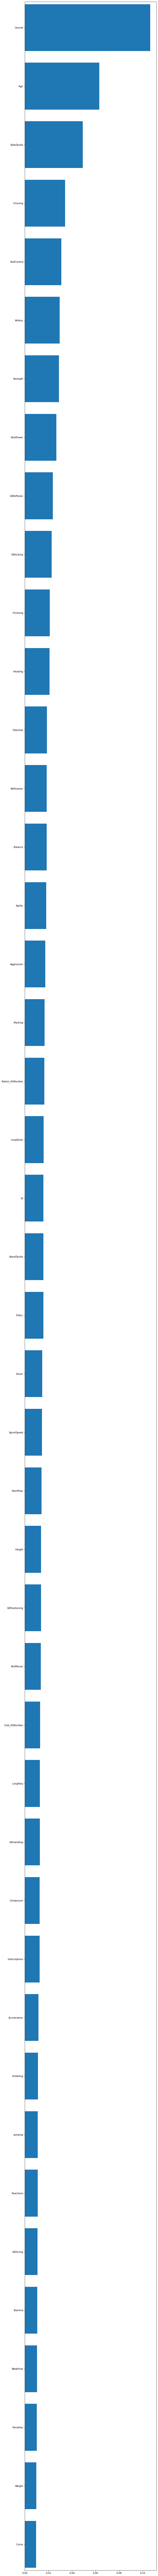

In [141]:
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,200)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

# create many features based on statistics per each country

In [25]:
#only keep countries that are in the 2022 World Cup
data_df = data_df[(data_df['Country'].isin(teams_2022))]
data_df

,Name,Country,Overall,Potential,Height,Weight,PreferredFoot,BirthDate,Age,PreferredPositions,PlayerWorkRate,WeakFoot,SkillMoves,Value,Wage,Nation,Nation_Position,Nation_KitNumber,Club,Club_Position,Club_KitNumber,Club_JoinedClub,Club_ContractLength,BallControl,Dribbling,Marking,SlideTackle,StandTackle,Aggression,Reactions,AttPosition,Interceptions,Vision,Composure,Crossing,ShortPass,LongPass,Acceleration,Stamina,Strength,Balance,SprintSpeed,Agility,Jumping,Heading,ShotPower,Finishing,LongShots,Curve,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes,Traits,Specialities
0,Lionel Messi,Argentina,93,93,170,72,L,"June 24, 1987",33,RW/ST/CF,Medium/Low,4,4,103500000.0,560000.0,Argentina,RW,10.0,FC Barcelona,CAM,10,"July 1, 2004",2021,96,96,32,24,35,44,94,93,40,95,96,85,91,91,91,72,69,95,80,91,68,70,86,95,94,93,94,75,88,14,6,11,15,8,Finesse Shot/Long Shot Taker (CPU AI Only)/Spe...,Dribbler/Distance Shooter/FK Specialist/Acroba...
2,Toni Kroos,Germany,88,88,183,76,R,"Jan. 4, 1990",30,CM,Medium/Medium,5,3,87500000.0,310000.0,Germany,LCM,8.0,Real Madrid,LCM,8,"July 17, 2014",2023,89,80,72,60,73,60,89,76,79,90,88,88,93,93,57,75,72,71,52,63,32,58,89,76,86,86,84,73,82,7,10,11,13,10,Long Passer (CPU AI Only)/Long Shot Taker (CPU...,Playmaker/Distance Shooter/Crosser/Complete Mi...
3,Raheem Sterling,England,88,90,170,69,R,"Dec. 8, 1994",25,LW/RW,High/Medium,4,4,114500000.0,270000.0,England,LW,7.0,Manchester City,LW,7,"July 14, 2015",2023,88,90,47,47,53,59,90,91,30,82,79,78,84,69,96,79,71,94,88,94,57,46,78,84,79,77,63,69,67,15,15,12,12,9,Flair/Speed Dribbler (CPU AI Only),Speedster/Dribbler/Acrobat
4,Eden Hazard,Belgium,88,88,175,74,R,"Jan. 7, 1991",29,LW,High/Medium,4,4,89500000.0,350000.0,Belgium,LF,10.0,Real Madrid,Sub,7,"July 1, 2019",2024,91,93,34,22,27,54,86,85,41,86,90,77,85,81,91,82,63,93,86,92,56,61,82,82,78,83,79,87,83,8,11,12,6,8,Injury Prone/Finesse Shot/Flair/Playmaker (CPU...,Dribbler/Acrobat
5,Ederson,Brazil,88,91,188,86,L,"Aug. 17, 1993",27,GK,Medium/Medium,3,1,92000000.0,195000.0,NaN,NaN,NaN,Manchester City,GK,31,"July 1, 2017",2024,40,23,29,8,15,38,87,20,27,70,70,20,57,59,64,41,78,48,63,60,66,14,70,14,18,15,20,17,18,86,86,82,93,88,Long Passer (CPU AI Only)/Rushes Out Of Goal/C...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19111,Neymar Jr,Brazil,91,91,175,68,R,"Feb. 5, 1992",28,LW/CAM,High/Medium,5,5,132000000.0,270000.0,NaN,NaN,NaN,Paris Saint-Germain,LW,10,"Aug. 3, 2017",2022,95,95,35,29,30,51,91,87,36,90,93,85,87,81,94,81,50,83,89,96,62,62,80,87,84,88,89,92,87,15,9,9,15,11,Injury Prone/Flair/Speed Dribbler (CPU AI Only...,Speedster/Dribbler/Playmaker/FK Specialist/Acr...
19112,Kevin De Bruyne,Belgium,91,91,181,70,R,"June 28, 1991",29,CM/CAM,High/High,5,4,127500000.0,370000.0,Belgium,RCM,7.0,Manchester City,RCM,17,"Aug. 30, 2015",2023,92,88,68,53,65,76,91,88,66,94,91,94,94,93,77,89,74,76,76,78,63,55,91,82,91,85,83,84,82,10,15,13,5,13,Injury Prone/Leadership/Early Crosser/Long Pas...,Dribbler/Playmaker/Engine/Distance Shooter/Cro...
19114,Cristiano Ronaldo,Portugal,92,92,187,83,R,"Feb. 5, 1985",35,ST/LW,High/Low,4,5,63000000.0,215000.0,Portugal,LS,7.0,Juventus,LS,7,"July 10, 2018",2022,92,88,28,24,32,63,95,95,29,82,95,84,82,77,87,84,78,71,91,87,95,90,94,95,93,81,76,84,86,14,7,11,15,11,Power Free-Kick/Flair/Long Shot Taker (CPU AI ...,Aerial Threat/Dribbler/Distance Shooter/Acroba...
19115,Robson Denho,Brazil,74,74,181,78,R,"Feb. 29, 1992",28,CDM/CM,High/High,3,2,3700000.0,12000.0,NaN,NaN,NaN,Atlético Clube Goianiense,CDM,44,"Jan. 1, 2019",2023,66,61,77,71,76,78,68,71,74,77,66,65,74,68,66,83,75,64,62,61,66,53,82,54,42,79,76,73,45,13,13,13,14,9,Power Free-Kick,NaN


In [26]:
data_df = data_df.drop(columns = 'ID')

KeyError: "['ID'] not found in axis"

In [27]:
data_df.columns
#which attribute features do we want out of the following column names?

Index(['Name', 'Country', 'Overall', 'Potential', 'Height', 'Weight',
       'PreferredFoot', 'BirthDate', 'Age', 'PreferredPositions',
       'PlayerWorkRate', 'WeakFoot', 'SkillMoves', 'Value', 'Wage', 'Nation',
       'Nation_Position', 'Nation_KitNumber', 'Club', 'Club_Position',
       'Club_KitNumber', 'Club_JoinedClub', 'Club_ContractLength',
       'BallControl', 'Dribbling', 'Marking', 'SlideTackle', 'StandTackle',
       'Aggression', 'Reactions', 'AttPosition', 'Interceptions', 'Vision',
       'Composure', 'Crossing', 'ShortPass', 'LongPass', 'Acceleration',
       'Stamina', 'Strength', 'Balance', 'SprintSpeed', 'Agility', 'Jumping',
       'Heading', 'ShotPower', 'Finishing', 'LongShots', 'Curve', 'FKAcc',
       'Penalties', 'Volleys', 'GKPositioning', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKReflexes', 'Traits', 'Specialities'],
      dtype='object')

In [29]:
data_df['Nation_Position'].unique()

array(['RW', 'LCM', 'LW', 'LF', nan, 'CDM', 'RCM', 'Sub', 'RCB', 'ST',
       'GK', 'CAM', 'LCB', 'RB', 'LDM', 'LB', 'LAM', 'RF', 'LM', 'RM',
       'CB', 'RS', 'LWB', 'RDM', 'RWB', 'LS', 'CM', 'RAM'], dtype=object)

In [18]:
# averaging stats of each player to get an overall 'score' for each team
average_for_teams = data_df.groupby(["Country"]).mean()
average_for_teams = average_for_teams.reset_index()
average_for_teams

,Country,Overall,Potential,Height,Weight,Age,WeakFoot,SkillMoves,Value,Wage,Nation_KitNumber,Club_KitNumber,BallControl,Dribbling,Marking,SlideTackle,StandTackle,Aggression,Reactions,AttPosition,Interceptions,Vision,Composure,Crossing,ShortPass,LongPass,Acceleration,Stamina,Strength,Balance,SprintSpeed,Agility,Jumping,Heading,ShotPower,Finishing,LongShots,Curve,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes
0,Argentina,67.806316,72.728421,178.816842,74.710526,26.442105,2.916842,2.473684,3.400971e+06,10585.157895,12.0,17.023158,60.943158,58.431579,47.120000,46.127368,47.711579,57.486316,63.905263,52.948421,46.431579,55.849474,60.892632,51.175789,60.735789,54.655789,64.472632,63.560000,64.737895,64.950526,64.333684,64.454737,65.637895,54.482105,61.314737,48.567368,49.886316,49.624211,44.330526,51.426316,45.255789,16.545263,16.392632,16.363158,16.362105,16.547368
1,Australia,61.027778,66.964286,180.722222,74.714286,24.496032,2.928571,2.206349,7.351613e+05,3219.758065,12.0,18.634921,53.511905,51.325397,44.349206,44.309524,46.083333,52.261905,55.380952,46.773810,44.166667,50.174603,54.865079,45.876984,54.797619,48.876984,63.956349,61.678571,62.765873,63.789683,63.849206,63.075397,62.797619,45.543651,51.015873,41.932540,40.527778,42.285714,36.539683,44.396825,37.210317,15.960317,16.285714,16.226190,16.400794,16.456349
2,Belgium,67.676667,73.903333,182.300000,75.126667,24.496667,3.173333,2.416667,4.685353e+06,14919.666667,12.0,25.203333,60.603333,57.073333,45.990000,46.456667,48.223333,55.353333,62.580000,49.653333,46.986667,55.933333,60.656667,52.840000,60.726667,56.400000,63.823333,60.303333,64.023333,64.216667,63.550000,64.530000,64.966667,50.426667,60.153333,45.413333,48.213333,48.943333,45.296667,48.043333,44.650000,18.266667,18.416667,18.183333,18.086667,18.506667
3,Brazil,70.967232,73.102825,180.677966,75.772881,26.162712,2.966102,2.554802,5.522758e+06,15841.109853,12.0,21.279096,64.129944,61.331073,49.257627,49.161582,51.312994,60.401130,68.138983,55.312994,50.683616,58.764972,64.836158,55.091525,63.977401,57.731073,66.393220,65.938983,67.662147,63.723164,66.449718,65.471186,65.855367,57.781921,63.784181,51.201130,53.818079,52.977401,49.543503,54.741243,49.570621,15.854237,16.118644,15.724294,15.892655,16.342373
4,Cameroon,67.447059,72.870588,182.705882,77.847059,24.682353,2.952941,2.352941,3.452169e+06,11857.831325,12.0,21.317647,62.388235,60.329412,48.552941,46.647059,50.105882,58.988235,62.647059,53.635294,48.000000,54.941176,60.529412,49.282353,62.400000,55.211765,67.988235,67.035294,71.082353,64.023529,68.788235,65.200000,69.211765,57.823529,61.247059,47.505882,48.917647,48.388235,39.505882,50.447059,44.705882,13.611765,14.235294,13.611765,13.270588,13.988235
5,Canada,62.831169,69.727273,182.207792,76.623377,24.597403,2.818182,2.207792,1.935120e+06,4889.333333,12.0,28.376623,52.922078,50.948052,43.142857,42.337662,45.454545,55.584416,58.103896,44.857143,43.142857,50.636364,55.259740,42.779221,54.610390,48.766234,62.454545,57.844156,65.337662,61.519481,62.285714,60.883117,64.662338,48.142857,55.000000,41.506494,41.688312,43.415584,34.961039,44.077922,38.727273,18.064935,18.857143,17.064935,16.740260,18.025974
6,Costa Rica,67.551724,69.344828,180.103448,75.172414,28.344828,2.827586,2.655172,2.177069e+06,8851.724138,NaN,19.448276,62.172414,59.241379,50.344828,46.689655,49.517241,64.689655,64.000000,54.724138,50.103448,56.034483,61.965517,52.827586,61.758621,56.000000,68.724138,63.827586,67.655172,66.275862,67.827586,66.448276,67.310345,53.793103,62.413793,49.206897,48.965517,50.827586,47.448276,49.137931,46.068966,12.827586,13.206897,13.310345,12.068966,14.241379
7,Croatia,69.451852,73.807407,185.533333,79.355556,25.755556,3.155556,2.377778,4.996037e+06,15454.814815,NaN,24.185185,60.614815,56.740741,49.333333,48.437037,51.162963,61.051852,65.333333,50.266667,49.118519,54.274074,61.762963,48.800000,61.318519,55.044444,61.392593,64.051852,70.237037,57.148148,61.866667,59.925926,62.659259,56.703

In [19]:
# median stats of each player to get an overall 'score' for each team
median_for_teams = data_df.groupby(["Country"]).median()
median_for_teams = median_for_teams.reset_index()
len(median_for_teams)

31

In [20]:
# median stats of each player to get an overall 'score' for each team
max_for_teams = data_df.groupby(["Country"]).max()
max_for_teams = max_for_teams.reset_index()
len(max_for_teams)

C:\Users\US11338\AppData\Local\Temp/ipykernel_1888/932889033.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_for_teams = data_df.groupby(["Country"]).max()


31

In [21]:
# min stats of each player to get an overall 'score' for each team
min_for_teams = data_df.groupby(["Country"]).min()
min_for_teams = min_for_teams.reset_index()
len(min_for_teams)

C:\Users\US11338\AppData\Local\Temp/ipykernel_1888/3565807590.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  min_for_teams = data_df.groupby(["Country"]).min()


31

In [22]:
std_for_teams = data_df.groupby(["Country"]).std()
std_for_teams = std_for_teams.reset_index()
len(std_for_teams)

31

#Features showing only certain positions: Goalie, for example

In [23]:
#only goalies
goalies = data_df.loc[data_df['Nation_Position'] == 'GK']
len(goalies)

20

In [34]:
#we only have 20 known goalies available
max_for_goalies = goalies.groupby("Country").max()
max_for_goalies = max_for_goalies.reset_index()
max_for_goalies

,Country,Name,Overall,Potential,Height,Weight,PreferredFoot,BirthDate,Age,PreferredPositions,PlayerWorkRate,WeakFoot,SkillMoves,Value,Wage,Nation,Nation_Position,Nation_KitNumber,Club,Club_Position,Club_KitNumber,Club_JoinedClub,Club_ContractLength,BallControl,Dribbling,Marking,SlideTackle,StandTackle,Aggression,Reactions,AttPosition,Interceptions,Vision,Composure,Crossing,ShortPass,LongPass,Acceleration,Stamina,Strength,Balance,SprintSpeed,Agility,Jumping,Heading,ShotPower,Finishing,LongShots,Curve,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes,Traits,Specialities
0,Argentina,Franco Armani,80,80,189,88,R,"Oct. 16, 1986",34,GK,Medium/Medium,3,1,7000000.0,17000.0,Argentina,GK,1.0,River Plate,GK,1,"Jan. 12, 2018",2022,35,19,15,19,13,45,77,17,21,55,53,18,37,29,41,35,81,39,45,37,67,19,50,11,17,15,16,20,18,81,78,76,67,86,Leadership/Cautious With Crosses,NaN
1,Australia,Mathew Ryan,79,81,184,82,R,"April 8, 1992",28,GK,Medium/Medium,4,1,15000000.0,50000.0,Australia,GK,1.0,Brighton & Hove Albion,GK,1,"July 1, 2017",2022,24,13,10,17,20,36,72,10,23,68,64,23,40,45,53,34,65,50,52,53,78,14,62,11,18,23,12,25,15,78,81,75,82,82,GK Long Throw/Rushes Out Of Goal,NaN
2,Belgium,Thibaut Courtois,89,90,199,96,L,"May 11, 1992",28,GK,Medium/Medium,3,1,82000000.0,250000.0,Belgium,GK,1.0,Real Madrid,GK,1,"Aug. 9, 2018",2024,23,13,20,16,18,23,84,13,15,44,66,14,33,35,42,38,70,45,52,61,68,13,56,14,17,19,20,27,12,85,84,89,74,88,GK Long Throw/Comes For Crosses,NaN
3,Brazil,Raphaelito Anjos,82,82,190,85,R,"Feb. 29, 1988",32,GK,Medium/Medium,2,1,15000000.0,32000.0,Brazil,GK,1.0,Grêmio,GK,16,"Jan. 1, 2019",2023,21,9,20,13,17,34,82,27,23,71,67,10,18,16,41,29,79,41,42,34,67,11,58,8,7,9,18,14,8,83,79,84,77,78,Team Player,NaN
4,Cameroon,André Onana,84,88,190,93,R,"April 2, 1996",24,GK,Medium/Medium,3,1,48000000.0,18000.0,Cameroon,GK,23.0,Ajax,GK,24,"Jan. 14, 2015",2022,38,26,12,14,18,32,83,11,15,64,64,15,43,53,64,39,79,53,62,68,80,20,65,12,17,30,17,27,13,83,84,80,87,86,Leadership/Rushes Out Of Goal/Comes For Crosse...,NaN
5,Canada,Milan Borjan,75,75,196,84,R,"Oct. 23, 1987",33,GK,Medium/Medium,2,1,NaN,NaN,Canada,GK,18.0,Free Agents,Res,99,"Feb. 6, 2020",2024,23,28,21,21,23,44,73,14,24,57,60,15,38,48,47,43,79,46,40,40,64,24,54,12,12,16,16,23,19,74,76,74,72,72,Comes For Crosses,NaN
6,Denmark,Kasper Schmeichel,84,84,189,89,R,"Nov. 5, 1986",34,GK,Medium/Medium,3,1,13500000.0,90000.0,Denmark,GK,1.0,Leicester City,GK,1,"June 1, 2011",2023,40,12,14,13,14,35,81,13,20,59,67,18,44,46,50,34,64,47,55,61,60,16,62,12,14,13,15,26,15,80,83,77,83,89,Leadership,NaN
7,Ecuador,Juan José Santigaro,74,74,198,87,R,"July 4, 1985",35,GK,Medium/Medium,3,1,NaN,NaN,Ecuador,GK,23.0,Free Agents,Res,99,"Jan. 1, 2014",2024,25,12,18,9,7,40,63,16,26,15,21,13,18,27,34,38,71,41,26,43,55,27,61,6,13,23,12,25,13,75,71,79,81,69,NaN,NaN
8,England,Jordan Pickford,80,83,185,77,L,"March 7, 1994",26,GK,Medium/Medium,5,1,21000000.0,65000.0,England,GK,1.0,Everton,GK,1,"June 15, 2017",2024,40,14,21,12,20,45,77,18,24,69,64,17,55,56,53,45,70,55,44,55,77,15,65,19,13,18,16,45,20,76,81,75,87,85,Long Passer (CPU AI Only)/Solid Player/Rushes ...,NaN
9,France,Hugo Lloris,87,87,188,82,L,"Dec. 26, 1986",33,GK,Medium/Medium,1,1,26000000.0,125000.0,France,GK,1.0,Tottenham Hotspur,GK,1,"Aug. 31, 2012",2022,34,10,29,18,10,31,85,10,27,30,65,13,50,50,65,41,43,54,62,55,74,10,51,10,14,11,10,40,11,84,89,82,68,90,Leadership/Rushes Out Of Goal/Comes For Crosses,NaN


In [30]:
data_df['PreferredPositions'].unique()

array(['RW/ST/CF', 'CM', 'LW/RW', 'LW', 'GK', 'CB', 'LM/CF/LW', 'CDM/CM',
       'CDM/RB', 'ST', 'CF/CAM', 'CF/ST', 'RM/CF/CAM', 'CAM/CM', 'CDM',
       'CM/CDM', 'LB', 'CAM/RM/RW', 'ST/LW/RW', 'CF', 'RB', 'RM/LM/RW',
       'CAM/RW/CM', 'RW/LW', 'LB/LM', 'CM/RM/LM', 'CAM/CM/CF', 'CB/CDM',
       'ST/LW', 'LM/RM/LW', 'LM', 'CAM/RW', 'CM/CDM/CAM', 'CAM/CF',
       'LM/ST', 'LM/LB/CM', 'CM/LM/LB', 'CDM/CB', 'CF/LW/CAM', 'CAM/RM',
       'CM/RM/ST', 'RB/RWB', 'RM', 'RWB/RB', 'RB/RM', 'ST/RW', 'RM/RB',
       'CAM/CM/LW', 'RM/RW', 'RM/CM', 'CF/ST/CAM', 'RB/CM', 'LM/CF',
       'RW/RM/CF', 'ST/RM/CF', 'LM/LWB', 'RB/LB', 'LB/LM/LWB',
       'CM/CAM/LM', 'RW/LW/CAM', 'CB/LB', 'CM/CAM/CDM', 'CAM/LW/CM',
       'LW/CAM/RW', 'LM/RW/LW', 'CM/CB/CDM', 'CAM/CM/ST', 'ST/RM',
       'RM/ST', 'ST/CAM', 'LM/LW/RM', 'CM/CAM', 'CM/LM', 'LM/RM',
       'CAM/RM/ST', 'RW/RM', 'LW/CAM', 'LM/LW', 'CM/LM/RM', 'CB/CDM/LB',
       'LM/ST/CAM', 'LW/RW/LM', 'LWB/LB', 'CDM/CM/CAM', 'ST/CF',
       'LB/LM/RM', 'LW/C

In [29]:
#only goalies
goalies2 = data_df.loc[data_df['PreferredPositions'] == 'GK']
len(goalies2)

1404

In [35]:
max_for_goalies2 = goalies2.groupby("Country").max()
max_for_goalies2 = max_for_goalies2.reset_index()
max_for_goalies2

C:\Users\US11338\AppData\Local\Temp/ipykernel_14156/2078748855.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_for_goalies2 = goalies2.groupby("Country").max()


,Country,Name,Overall,Potential,Height,Weight,PreferredFoot,BirthDate,Age,PreferredPositions,PlayerWorkRate,WeakFoot,SkillMoves,Value,Wage,Nation_KitNumber,Club,Club_Position,Club_KitNumber,Club_ContractLength,BallControl,Dribbling,Marking,SlideTackle,StandTackle,Aggression,Reactions,AttPosition,Interceptions,Vision,Composure,Crossing,ShortPass,LongPass,Acceleration,Stamina,Strength,Balance,SprintSpeed,Agility,Jumping,Heading,ShotPower,Finishing,LongShots,Curve,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes,Specialities
0,Argentina,Willy Caballero,82,84,196,94,R,"Sept. 28, 1981",42,GK,Medium/Medium,4,1,25500000.0,85000.0,23.0,Yeni Malatyaspor,Sub,41,"July 1, 2013",42,25,30,24,25,45,82,20,29,70,69,25,60,54,65,45,82,68,65,70,75,26,62,20,20,33,30,70,20,82,82,80,83,86,NaN
1,Australia,Vedran Janjetović,79,81,198,95,R,"Sept. 28, 1999",39,GK,Medium/Medium,4,1,15000000.0,50000.0,18.0,Western United FC,Sub,46,2023,27,19,27,20,20,44,73,20,25,68,64,23,40,45,53,40,74,58,55,66,78,19,62,19,18,27,21,41,20,78,81,75,82,82,NaN
2,Belgium,Yannick Thoelen,89,90,199,96,R,"Sept. 7, 1993",41,GK,Medium/Medium,4,1,82000000.0,250000.0,13.0,Willem II,Sub,99,2025,36,29,23,22,22,36,84,18,26,58,66,20,48,46,60,44,78,64,58,66,75,22,60,17,20,23,22,41,19,85,84,89,80,88,NaN
3,Brazil,Wiliam Santinho,90,91,196,93,R,"Sept. 3, 1993",40,GK,Medium/Medium,5,1,102000000.0,195000.0,23.0,Vasco da Gama,Sub,99,"July 13, 2019",40,27,29,20,20,47,88,27,44,77,71,33,57,59,64,62,85,68,63,74,83,30,70,25,22,31,23,34,29,91,86,88,93,89,NaN
4,Cameroon,Simon Omossola,84,88,190,93,R,"May 5, 1998",24,GK,Medium/Medium,3,1,48000000.0,18000.0,23.0,Stoke City,Sub,99,2024,38,26,19,15,18,32,83,12,16,64,64,15,43,53,64,43,79,53,62,68,80,20,65,18,17,30,20,27,17,83,84,80,87,86,NaN
5,Canada,Thomas Hasal,75,75,196,88,R,"Oct. 23, 1987",41,GK,Medium/Medium,3,1,2000000.0,4200.0,18.0,Vancouver Whitecaps FC,Sub,99,2024,35,28,30,21,23,44,73,17,24,57,60,19,41,48,54,43,79,63,49,59,72,24,54,20,16,16,16,26,20,74,76,74,72,75,NaN
6,Costa Rica,Keylor Navas,88,88,185,80,R,"Dec. 15, 1986",33,GK,Medium/Medium,3,1,29500000.0,130000.0,NaN,Paris Saint-Germain,GK,1,2023,19,16,28,14,14,32,86,16,20,68,67,11,30,37,54,39,75,61,53,60,74,11,56,15,13,11,15,25,11,83,90,83,75,90,NaN
7,Croatia,Simon Sluga,81,86,201,99,R,"May 30, 1991",33,GK,Medium/Medium,3,1,30000000.0,33000.0,NaN,Sampdoria,Sub,71,"July 1, 2018",36,19,24,21,22,39,80,17,23,61,64,20,46,56,57,38,75,53,54,65,61,15,56,15,19,20,20,22,18,79,81,78,74,83,NaN
8,Denmark,Thomas Mikkelsen,84,84,199,99,R,"Sept. 25, 1995",39,GK,Medium/Medium,4,1,13500000.0,90000.0,22.0,Wolverhampton Wanderers,Sub,91,"July 1, 2018",44,24,28,18,19,36,81,19,29,68,67,20,57,55,51,44,79,62,55,61,68,28,62,20,19,26,20,42,22,80,83,77,83,89,NaN
9,Ecuador,Álvaro Preciado,74,75,199,104,R,"Sept. 8, 2000",36,GK,Medium/Medium,4,1,2000000.0,10500.0,23.0,Vélez Sarsfield,Sub,99,2025,31,24,26,24,21,57,72,20,26,66,66,21,37,57,63,50,85,62,56,66,83,29,61,19,20,23,23,35,20,75,72,79,81,73,NaN


# Dataset does not identify the position each player will play in the world cup yet. However, we can look at preferred position to get a clue.

In [37]:
data_df['Nation_Position'].value_counts()

Sub    240
GK      20
LCB     20
RCB     20
LB      16
LCM     16
RB      16
RCM     16
ST      16
RW      10
LW      10
CDM      9
CAM      8
LM       7
RM       7
CB       4
LS       4
RDM      4
RS       4
LDM      4
LWB      2
RWB      2
RF       1
LAM      1
LF       1
CM       1
RAM      1
Name: Nation_Position, dtype: int64

In [ ]:
# Connect to local database

protocol = 'postgresql'
username = 'postgres'
password = 'admin'
host = 'localhost'
port = 5432
database_name = 'players_db'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
rds_connection_string

In [ ]:
# Checking Tables Names in PgAdmin

engine.table_names()

In [ ]:
player_info_df.to_sql(name='player_info', con=engine, if_exists='replace', index=False)


In [ ]:
matches_df.to_sql(name='matches', con=engine, if_exists='replace', index=False)

In [ ]:
averages_for_teams.to_sql(name='team_averages', con=engine, if_exists='replace', index=False)